In [8]:
from dataset import bearing_dataset, read_mat
import numpy as np
import matplotlib.pyplot as plt
import os

from torch import nn, optim
from torch.utils.data import DataLoader
from torch_tool.trainer import TorchModule
from torch_tool.callbacks import ModelCheckpoint, EarlyStopping

## Read data

In [2]:
class_lst = ['Normal', 'Inner_break', 'Outer_break']
train = True
trainset = bearing_dataset(path = './data/Image/train', class_lst = class_lst, train = train)
TrainLoader = DataLoader(trainset, batch_size = 128)

valset = bearing_dataset(path = './data/Image/test', class_lst = class_lst, train = train)
ValLoader = DataLoader(valset, batch_size = 128)

Anchor is Normal, and Negative is Outer_break


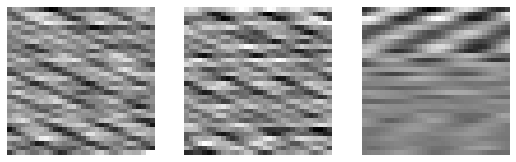

In [3]:
imgs = trainset[0]
print(f'Anchor is {class_lst[imgs[3]]}, and Negative is {class_lst[imgs[4]]}')
plt.figure(figsize = (9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[i].reshape(32, 32), cmap = 'gray')
    plt.axis('off')
# print(anchor.shape, pos.shape, neg.shape)
plt.show()

## Define encoding model

In [4]:
class BearingNet(TorchModule):
    def __init__(self, in_channels = 1, encode_size = 128, use_gpu = True, gpu_id = 0):
        super().__init__(use_gpu = use_gpu, gpu_id = gpu_id)

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 20, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(in_channels = 20, out_channels = 16, kernel_size = 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3),
            nn.ReLU(),

            nn.Flatten()
        )

        self.fully_connected = nn.Sequential(
            nn.BatchNorm1d(144),
            nn.Linear(144, 132),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(132),
            nn.Linear(132, encode_size),
            nn.Dropout(0.5),
            nn.Sigmoid()
        )

        self.criterion = nn.TripletMarginLoss()

    def forward(self, img):
        out = self.cnn(img)
        out = self.fully_connected(out)

        return out

    def training_step(self, batch):
        anch, pos, neg, _, _ = batch
        anch_out = self(anch)
        pos_out = self(pos)
        neg_out = self(neg)
        loss = self.criterion(anch_out, pos_out, neg_out)

        return loss

    def val_step(self, batch):
        anch, pos, neg, _, _ = batch
        anch_out = self(anch)
        pos_out = self(pos)
        neg_out = self(neg)
        loss = self.criterion(anch_out, pos_out, neg_out)

        return loss

    def set_optimizer(self):
        optimizer = optim.Adam(
            self.parameters(), lr=0.001, 
            betas=(0.9, 0.999), eps=1e-08, 
            weight_decay=1e-2, amsgrad=False
        )

        return optimizer

In [17]:
model = BearingNet()

if not os.path.isdir('./checkpoint'):
    os.mkdir('./checkpoint')

filepath = './checkpoint/model_{epoch}_{loss:.2f}.pth'

ckpt1 = ModelCheckpoint(
    filepath = filepath, monitor='loss', verbose=True,
    save_best_only=False, mode='auto', period=2
)
# ckpt2 = EarlyStopping(
#     monitor="loss", min_delta=0.001,
#     patience=10, verbose=1, mode="auto",
#     restore_best_weights=True
# )
callbacks = [ckpt1]

----------------------------------
| The model use Cuda:0 to train. |
---------------------------------- 



In [18]:
history = model.fit_dataloader(TrainLoader, epochs = 30, callbacks = callbacks, verbose = True)

Epoch 1/30 :
[========================================] 100%	loss: 0.7569  loss: 0.7569

Epoch 00001: saving model to ./checkpoint/model_1_0.76.pth

Epoch 2/30 :
[========================================] 100%	loss: 0.4441  loss: 0.4441

Epoch 00002: saving model to ./checkpoint/model_2_0.44.pth

Epoch 3/30 :
[========================================] 100%	loss: 0.2976  loss: 0.2976

Epoch 00003: saving model to ./checkpoint/model_3_0.30.pth

Epoch 4/30 :
[========================================] 100%	loss: 0.1703  loss: 0.1703

Epoch 00004: saving model to ./checkpoint/model_4_0.17.pth

Epoch 5/30 :
[========================================] 100%	loss: 0.0831  loss: 0.0831

Epoch 00005: saving model to ./checkpoint/model_5_0.08.pth

Epoch 6/30 :
[========================================] 100%	loss: 0.0327  loss: 0.0327

Epoch 00006: saving model to ./checkpoint/model_6_0.03.pth

Epoch 7/30 :
[========================================] 100%	loss: 0.0211  loss: 0.0211

Epoch 00007: savi

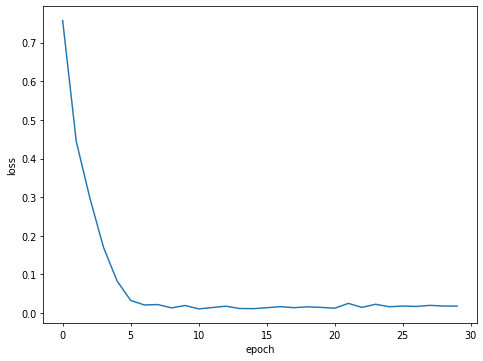

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6), dpi = 70)
plt.plot(history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Get encoding vector from Normal, Inner_break, Outer_break

In [20]:
import torch
from dataset import get_pattern
model = BearingNet()
model_path = './checkpoint/model_23_0.01.pth'
params = torch.load(model_path)
model.load_state_dict(params)
pattern_vec_dict = get_pattern(model)

----------------------------------
| The model use Cuda:0 to train. |
---------------------------------- 



In [21]:
from dataset import get_dict

train_dict = get_dict(path = './data/Image/train')
class_lst = ['Normal', 'Inner_break', 'Outer_break']
label_lst = []
vec_lst = torch.zeros(1, 128)
count = 0

with torch.no_grad():
    for cla in class_lst:
        length = train_dict[cla].shape[0]
        label_lst += [count for _ in range(length)]
        vec = model(train_dict[cla])
        vec_lst = torch.cat([vec_lst, vec], dim = 0)
        count += 1

vec_lst = vec_lst[1:].numpy()
label_lst = np.array(label_lst)
print(vec_lst.shape, label_lst.shape)

(1071, 128) (1071,)


In [22]:
path = './data/Vector'
np.save(f'{path}/X.npy', vec_lst)
np.save(f'{path}/Y.npy', label_lst)

# Randomforest model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Read data
path = './data/Vector'
X = np.load(f'{path}/X.npy')
Y = np.load(f'{path}/Y.npy')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Define model
RF = RandomForestClassifier(
    n_estimators=150, criterion='gini', 
    max_depth=7, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
    max_features='sqrt', max_leaf_nodes=None, 
    min_impurity_decrease=0.1, min_impurity_split=None, 
    bootstrap=True, oob_score=False, 
    n_jobs=16, random_state=None, 
    class_weight=None, ccp_alpha=0.0
)

# DL = BearingNet()
# DL.load_state_dict('./checkpoint/model_8_0.94.pth')

(856, 128) (215, 128) (856,) (215,)


In [24]:
# Training
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=7, max_features='sqrt',
                       min_impurity_decrease=0.1, n_estimators=150, n_jobs=16)

In [25]:
# Evaluation
pred = RF.predict(x_train)
print('Training report:')
print(classification_report(y_train, pred))

print()

pred = RF.predict(x_test)
print('Testing report:')
print(classification_report(y_test, pred))

Training report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00       279
           2       1.00      1.00      1.00       288

    accuracy                           1.00       856
   macro avg       1.00      1.00      1.00       856
weighted avg       1.00      1.00      1.00       856


Testing report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        69

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



In [26]:
from joblib import dump

dump(RF, './checkpoint/RF_0.87.pth')

['./checkpoint/RF_0.87.pth']